In [9]:
import os
import matplotlib.pyplot as mp
%matplotlib inline
from matplotlib.colors import LogNorm
import numpy as np
from matplotlib.ticker import ScalarFormatter
from astropy.wcs import WCS
from astropy.io import fits

import sys
sys.path.insert(0,'/home/jill/python/CRRP-photometry/')
import analysis_routines
import coordinates



from scipy.spatial import ConvexHull
import hull
from skimage.feature import corner_harris, corner_peaks

In [2]:
def concave(points,alpha_x=150,alpha_y=150):
    points = [(i[0],i[1]) if type(i) <> tuple else i for i in points]
    de = Delaunay(points)
    dec = []
    a = alpha_x
    b = alpha_y
    for i in de.simplices:
        tmp = []
        j = [points[c] for c in i]
        if abs(j[0][1] - j[1][1])>a or abs(j[1][1]-j[2][1])>a or abs(j[0][1]-j[2][1])>a or abs(j[0][0]-j[1][0])>b or abs(j[1][0]-j[2][0])>b or abs(j[0][0]-j[2][0])>b:
            continue
        for c in i:
            tmp.append(points[c])
        dec.append(tmp)
    G = nx.Graph()
    for i in dec:
            G.add_edge(i[0], i[1])
            G.add_edge(i[0], i[2])
            G.add_edge(i[1], i[2])
    ret = []
    for graph in nx.connected_component_subgraphs(G):
        ch = ConvexHull(graph.nodes())
        tmp = []
        for i in ch.simplices:
            tmp.append(graph.nodes()[i[0]])
            tmp.append(graph.nodes()[i[1]])
        ret.append(tmp)
    return ret  

In [7]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """


    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    #coords = np.array([point.coords[0] for point in points])
    coords = points
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points


from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = mp.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig



In [10]:
targets = ['NGC6121', 'NGC3201', 'NGC5904', 'NGC7078', 'NGC6402']
cluster_ras = ['16:23:35.22', '10:17:36.82', '15:18:33.22', '21:29:58.33', '17:37:36.10']
cluster_decs = ['-26:31:32.7', '-46:24:44.9', '02:04:51.7', '12:10:01.2', '-03:14:45.3']

target = targets[4]
top_dir = '/mnt/data/public/jill/CRRP/'

In [11]:
# import DSS image
# find optical FOV
# find NIR FOV
# find MIR FOV
# overplot clement RRL 
top_dir = '/mnt/data/public/jill/CRRP/'
os.chdir(top_dir+'clement')
clem_file = target+'.txt'

clem_dtype = np.dtype([('id', 'a8'), ('ra', 'a11'), ('dec', 'a11'), ('type', 'a5')])
clem_data = np.loadtxt(clem_file, dtype=clem_dtype, usecols=(0,1,2,8))

RRc = clem_data['type'] == 'RR1'
RRab = clem_data['type'] == 'RR0'
RRL = (clem_data['type'] == 'RR0') | (clem_data['type'] == 'RR1')

print 'Found {} RR Lyrae stars.'.format(len(clem_data['id'][RRL]))
print clem_data['dec'][RRL]


rrl_ra, rrl_dec = coordinates.radec_string2deg(clem_data['ra'][RRL], clem_data['dec'][RRL])


Found 111 RR Lyrae stars.
['-03:16:14.8' '-03:13:32.9' '-03:13:16.5' '-03:14:10.2' '-03:15:25.1'
 '-03:18:09.9' '-03:18:28.5' '-03:17:43.1' '-03:16:44.2' '-03:12:17.7'
 '-03:15:21.3' '-03:15:07.7' '-03:14:43.3' '-03:13:07.1' '-03:12:40.3'
 '-03:13:11.0' '-03:10:04.7' '-03:13:30.4' '-03:19:57.6' '-03:14:57.7'
 '-03:14:13.7' '-03:12:18.7' '-03:14:31.1' '-03:14:18.6' '-03:20:28.4'
 '-03:14:27.1' '-03:15:02.7' '-03:14:46.1' '-03:14:47.1' '-03:14:33.5'
 '-03:14:23.4' '-03:12:47.6' '-03:15:50.7' '-03:14:18.1' '-03:14:04.7'
 '-03:15:03.8' '-03:19:52.2' '-03:12:58.8' '-03:17:48.8' '-03:16:40.9'
 '-03:15:18.5' '-03:14:15.9' '-03:13:50.6' '-03:15:28.6' '-03:17:19.4'
 '-03:15:05.8' '-03:15:08.1' '-03:15:34.8' '-03:14:55.7' '-03:13:46.5'
 '-03:14:47.4' '-03:15:00.3' '-03:17:14.7' '-03:14:22.7' '-03:14:32.4'
 '-03:15:16.2' '-03:14:50.5' '-03:17:28.5' '-03:14:46.3' '-03:12:47.8'
 '-03:15:20.5' '-03:14:56.0' '-03:14:03.3' '-03:14:46.4' '-03:14:48.2'
 '-03:15:12.0' '-03:14:40.9' '-03:16:10.2' '-03:15:

Changed directory to /mnt/data/public/jill/CRRP/NGC6402


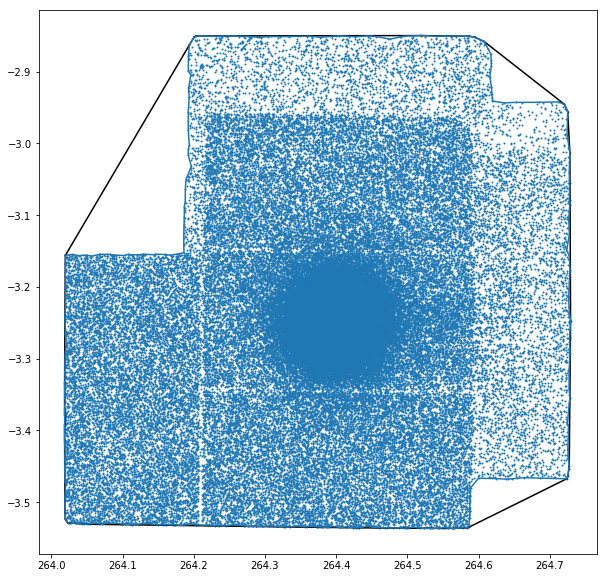

In [22]:
# find fields of view in different filters
os.chdir(top_dir+target)
print 'Changed directory to {}'.format(top_dir+target)

#read in catalog
data = analysis_routines.read_merged_catalog(target)

ra, dec = coordinates.hms2deg(data['ra_h'], data['ra_m'], data['ra_s'], data['dec_d'], data['dec_m'], data['dec_s'])
good_opt = data['V'] < 90
#good_nir = data['J'] < 90
good_irac1 = data['3.6'] < 90
good_irac2 = data['4.5'] < 90

fig = mp.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(ra[good_opt], dec[good_opt], s=1)

opt_points = np.array(zip(ra[good_opt], dec[good_opt]))
opt_points2 = list(zip(ra[good_opt], dec[good_opt]))
#nir_points = np.array(zip(ra[good_nir], dec[good_nir]))
irac1_points = np.array(zip(ra[good_irac1], dec[good_irac1]))
irac2_points = np.array(zip(ra[good_irac2], dec[good_irac2]))
opt_hull = ConvexHull(opt_points)
#nir_hull = ConvexHull(nir_points)
irac1_hull = ConvexHull(irac1_points)
irac2_hull = ConvexHull(irac2_points)


#test = concave(opt_points)
#print test

#concave_hull, edge_points = alpha_shape(opt_points, alpha=0.2)

for simplex in opt_hull.simplices:
    ax.plot(opt_points[simplex, 0], opt_points[simplex, 1], 'k-')


concave_hull = hull.concave(opt_points2, 50)
hull_array = np.array(concave_hull)
ax.plot(hull_array[:,0], hull_array[:,1])
#cave = plot_polygon(concave_hull)
#cave = mp.scatter(ra[good_opt], dec[good_opt], s=1)

mp.show()



TypeError: For this input type lists must contain either int or Ellipsis

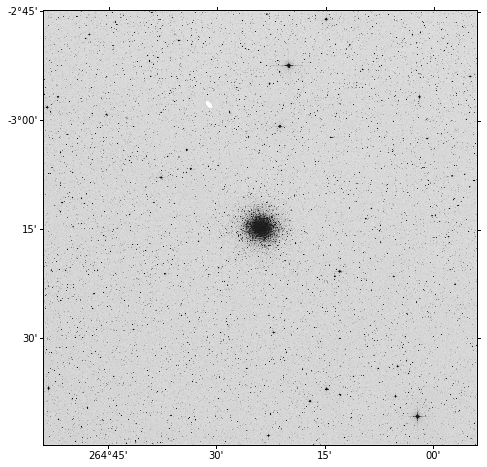

In [24]:
top_dir = '/mnt/data/public/jill/CRRP/'
os.chdir(top_dir+'clement')
hdu = fits.open(target+'-dss.fits')[0]
wcs = WCS(hdu.header)
fig = mp.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=wcs)
mp.imshow(hdu.data, origin='lower', cmap='gray_r')#, norm=LogNorm())

irac1_x = np.append(irac1_points[irac1_hull.vertices, 0], irac1_points[irac1_hull.vertices[0], 0])
irac1_y = np.append(irac1_points[irac1_hull.vertices, 1], irac1_points[irac1_hull.vertices[0], 1])
irac2_x = np.append(irac2_points[irac2_hull.vertices, 0], irac2_points[irac2_hull.vertices[0], 0])
irac2_y = np.append(irac2_points[irac2_hull.vertices, 1], irac2_points[irac2_hull.vertices[0], 1])
opt_x = np.append(opt_points[opt_hull.vertices, 0], opt_points[opt_hull.vertices[0], 0])
opt_y = np.append(opt_points[opt_hull.vertices, 1], opt_points[opt_hull.vertices[0], 1])
#nir_x = np.append(nir_points[nir_hull.vertices, 0], nir_points[nir_hull.vertices[0], 0])
#nir_y = np.append(nir_points[nir_hull.vertices, 1], nir_points[nir_hull.vertices[0], 1])

ax.plot(irac1_x, irac1_y, '-', color='red', transform=ax.get_transform('fk5'))
ax.plot(irac2_x, irac2_y, 'k-', color='m', transform=ax.get_transform('fk5'))
ax.plot(hull_array[:,0], hull_array[:,1], '-', color='blue', transform=ax.get_transform('fk5'))
#ax.plot(nir_x, nir_y, 'k-', transform=ax.get_transform('fk5'))

ax.scatter(rrl_ra, rrl_dec, edgecolor='green', alpha=0.5, facecolor='none', transform=ax.get_transform('fk5'))
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

x_formatter = ScalarFormatter(useOffset=False)
mp.gca().xaxis.set_major_formatter(x_formatter)
#mp.show()
mp.savefig(target+'-snapshot.pdf', format='pdf')